# Analysis of Crop Overlap and Agricultural Systems

**Goal:** To create a single map that visualizes where the world's major crops are grown, paying special attention to areas where multiple crops are cultivated.

Loaded and processed average yield for maize.
Loaded and processed average yield for rice.
Loaded and processed average yield for wheat.
Loaded and processed average yield for soybean.

Saved crop count map to: ../reports/figures/global_crop_count_map.png


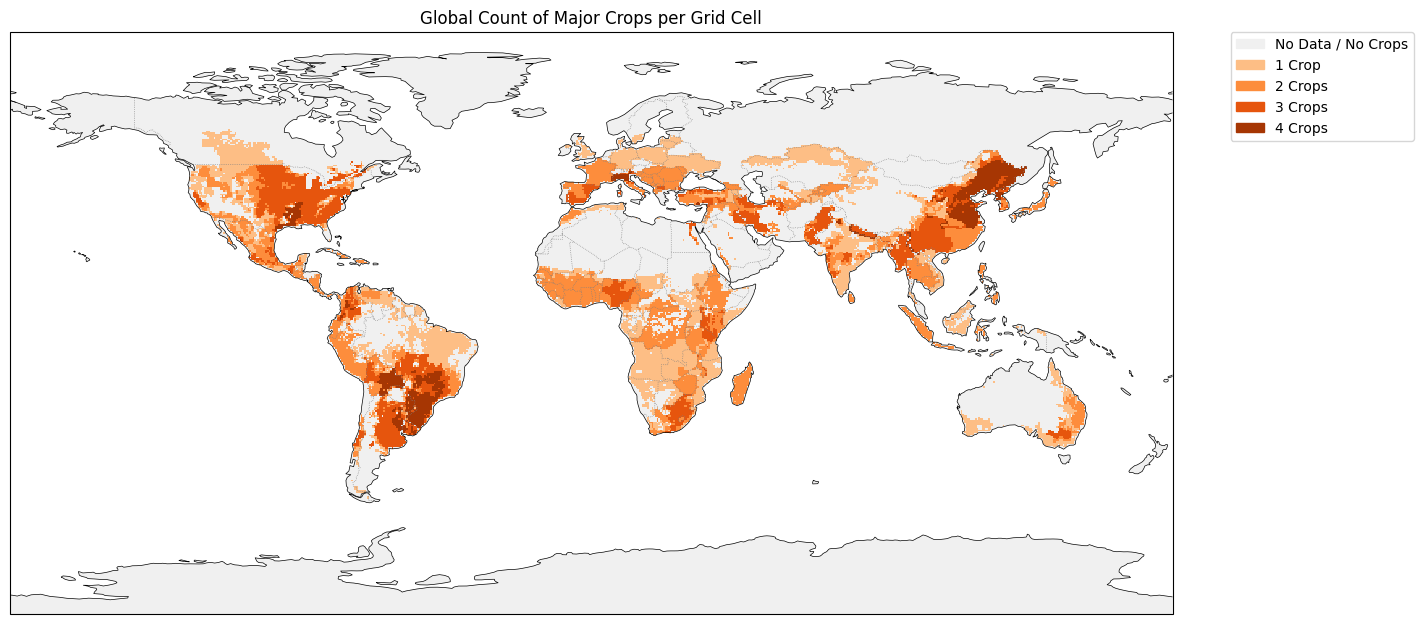

In [1]:
# Cell 1: Setup and Crop Count Map (Updated with Save Functionality)
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import matplotlib.patches as mpatches

# --- 1. Load Average Yield Data for the Four Main Crops ---
CROPS_TO_LOAD = ['maize', 'rice', 'wheat', 'soybean']
DATA_DIR = '../data/'
avg_yields = {}

for crop in CROPS_TO_LOAD:
    data_path = os.path.join(DATA_DIR, crop, 'yield_*.nc4')
    with xr.open_mfdataset(data_path, combine='nested', concat_dim='time') as ds:
        avg_yields[crop] = ds['var'].mean(dim='time').compute()
        print(f"Loaded and processed average yield for {crop}.")

# --- 2. Create the Crop Count Map ---
crop_count = xr.zeros_like(avg_yields['maize'])
for crop in CROPS_TO_LOAD:
    crop_count = crop_count + xr.where(avg_yields[crop] > 0, 1, 0)

# --- 3. Plot the Crop Count Map with Custom Colors ---
fig, ax = plt.subplots(figsize=(15, 8), subplot_kw={'projection': ccrs.PlateCarree()})
land_color = '#f0f0f0'
ax.add_feature(cfeature.LAND, facecolor=land_color)
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray', linewidth=0.5)

# --- Your Custom Color Scheme ---
count_colors = ['#fdbe85', '#fd8d3c', '#e6550d', '#a63603']
cmap = plt.matplotlib.colors.ListedColormap(count_colors)

# Plot the data
crop_count.where(crop_count > 0).plot(
    ax=ax,
    cmap=cmap,
    levels=[0.5, 1.5, 2.5, 3.5, 4.5],
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

# Create Custom Legend
legend_labels = {
    'No Data / No Crops': land_color,
    '1 Crop': count_colors[0],
    '2 Crops': count_colors[1],
    '3 Crops': count_colors[2],
    '4 Crops': count_colors[3]
}
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in legend_labels.items()]
ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

ax.set_title('Global Count of Major Crops per Grid Cell')

# --- 4. Save the Figure ---
output_dir = '../reports/figures/'
os.makedirs(output_dir, exist_ok=True)
file_path = os.path.join(output_dir, 'global_crop_count_map.png')
plt.savefig(file_path, dpi=300, bbox_inches='tight')
print(f"\nSaved crop count map to: {file_path}")

plt.show()

## Mapping Major Agricultural Systems

A crop count is useful, but it doesn't tell us *which* crops are grown together. Here, we create a categorical map to identify some of the world's most significant agricultural systems:
- **Maize-Soybean System:** The classic rotation in the Americas.
- **Rice-Wheat System:** A critical system in South and East Asia.
- **Other combinations and single crops.**


Saved agricultural systems map to: ../reports/figures/global_ag_systems_map.png


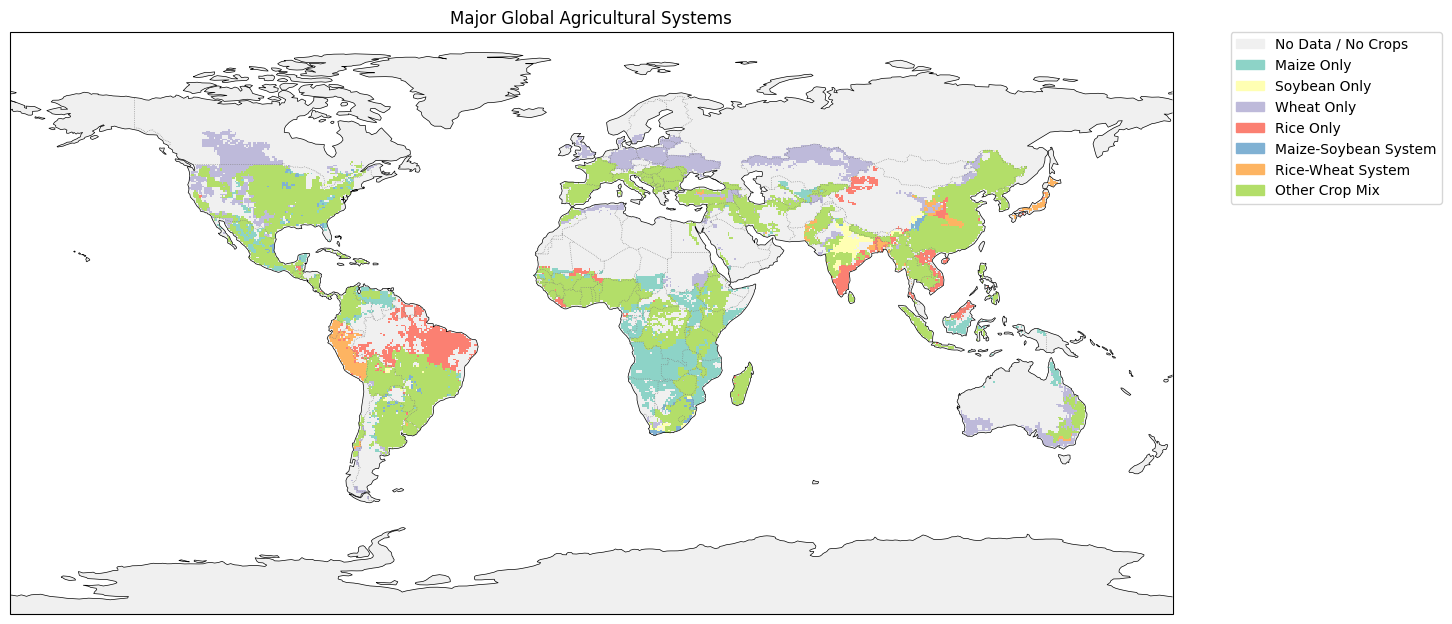

In [3]:
# Cell 2: Major Agricultural Systems Map (Corrected Logic v2)
import matplotlib.patches as mpatches

# --- 1. Create Boolean Masks and Crop Count (same as before) ---
maize_present = avg_yields['maize'] > 0
rice_present = avg_yields['rice'] > 0
wheat_present = avg_yields['wheat'] > 0
soybean_present = avg_yields['soybean'] > 0
crop_count = (maize_present.astype(int) + rice_present.astype(int) + wheat_present.astype(int) + soybean_present.astype(int))

# --- 2. Define Mutually Exclusive Categories ---
# This new logic ensures that a grid cell can only belong to one category.
# We check for the most specific cases first.

# Start with a grid of zeros (No Data / No Crops)
systems_map = xr.zeros_like(avg_yields['maize'], dtype=int)

# CATEGORY 7: Other Crop Mix (any combination that isn't one of our specific systems)
# We start by assigning this to any cell with 2 or more crops.
systems_map = xr.where(crop_count >= 2, 7, systems_map)

# CATEGORY 6: Rice-Wheat System (ONLY Rice and Wheat)
# This condition is now very strict.
systems_map = xr.where((rice_present & wheat_present) & (crop_count == 2), 6, systems_map)

# CATEGORY 5: Maize-Soybean System (ONLY Maize and Soybean)
# This condition is also now very strict.
systems_map = xr.where((maize_present & soybean_present) & (crop_count == 2), 5, systems_map)

# CATEGORY 1-4: Single Crops (where crop count is exactly 1)
systems_map = xr.where(rice_present & (crop_count == 1), 4, systems_map)
systems_map = xr.where(wheat_present & (crop_count == 1), 3, systems_map)
systems_map = xr.where(soybean_present & (crop_count == 1), 2, systems_map)
systems_map = xr.where(maize_present & (crop_count == 1), 1, systems_map)


# --- 3. Create a Custom Colormap and Legend (same as before) ---
category_labels = {
    'No Data / No Crops': '#f0f0f0',
    'Maize Only': '#8dd3c7',
    'Soybean Only': '#ffffb3',
    'Wheat Only': '#bebada',
    'Rice Only': '#fb8072',
    'Maize-Soybean System': '#80b1d3',
    'Rice-Wheat System': '#fdb462',
    'Other Crop Mix': '#b3de69'
}
cmap_colors = [v for k, v in category_labels.items() if k != 'No Data / No Crops']
cmap = plt.matplotlib.colors.ListedColormap(cmap_colors)

# --- 4. Plot the Map (same as before) ---
fig, ax = plt.subplots(figsize=(15, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.LAND, facecolor=category_labels['No Data / No Crops'])
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray', linewidth=0.5)

systems_map.where(systems_map > 0).plot(ax=ax, cmap=cmap, transform=ccrs.PlateCarree(), add_colorbar=False)

# Create a dynamic legend that only shows categories present in the map
unique_cats = np.unique(systems_map)
legend_patches = [mpatches.Patch(color=v, label=k) for k, v in category_labels.items() if (list(category_labels.values()).index(v) in unique_cats)]
ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

ax.set_title('Major Global Agricultural Systems')

# --- 5. Save the Figure (same as before) ---
output_dir = '../reports/figures/'
os.makedirs(output_dir, exist_ok=True)
file_path = os.path.join(output_dir, 'global_ag_systems_map.png')
plt.savefig(file_path, dpi=300, bbox_inches='tight')
print(f"\nSaved agricultural systems map to: {file_path}")

plt.show()